### Forecasting Sticker Sales

#### 1. Data Load & Analysis

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

train = pd.read_csv("./playground-series-s5e1/train.csv")
train.date = pd.to_datetime(train.date)
print("Train shape:", train.shape )
train.head()

Train shape: (230130, 6)


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


##### 1-1 GDP에 대한 정보 가져와서 concat

In [7]:
import requests 
def get_gdp_per_capita(alpha3, year):
    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3,year)).json()
    return response[1][0]['value']

alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
train['alpha3'] = train['country'].map(dict(zip(
    np.sort(train['country'].unique()), alpha3s)))
years = np.sort(train['date'].dt.year.unique())
train['year'] = train['date'].dt.year

gdp = np.array([
    [get_gdp_per_capita(alpha3, year) for year in years]
    for alpha3 in alpha3s
])
gdp = pd.DataFrame(gdp, index=alpha3s, columns=years)

train['GDP'] = train.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)
train = train.drop(['alpha3','year'],axis=1)

train["num_sold"] /= train["GDP"]
store_ratio = train.groupby("store").num_sold.mean().to_dict()
train["store_ratio"] = train.store.map(store_ratio)
train["num_sold"] /= train["store_ratio"]

train.head()

,id,date,country,store,product,num_sold,GDP,store_ratio
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,47560.666601,0.008957
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,2.283955,47560.666601,0.008957
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,2.126684,47560.666601,0.008957
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,0.992922,47560.666601,0.008957
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,1.152541,47560.666601,0.008957


##### 1-2 Train Data 만들기

- Data Scaling 진행

Countries: ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
Stores: ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart']
Products: ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']


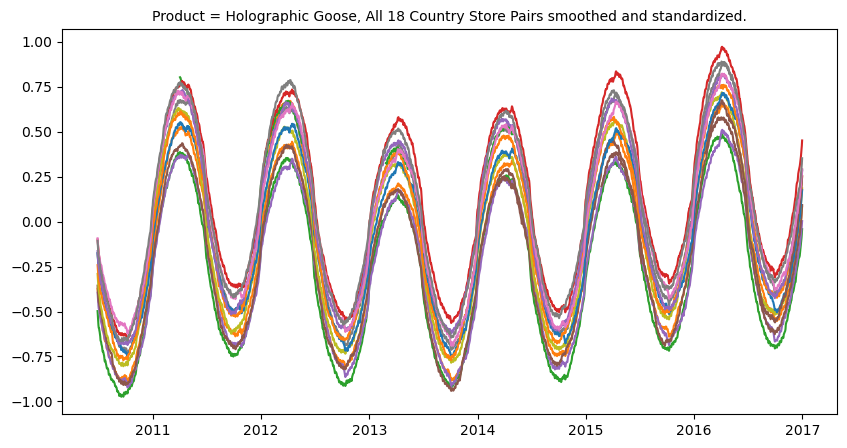

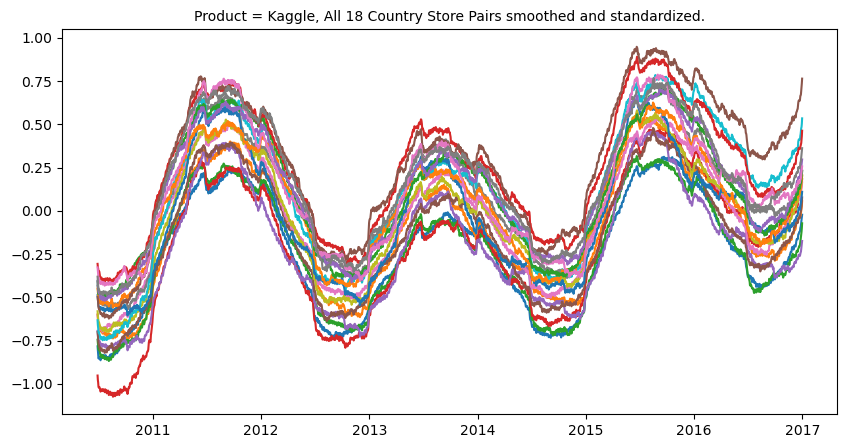

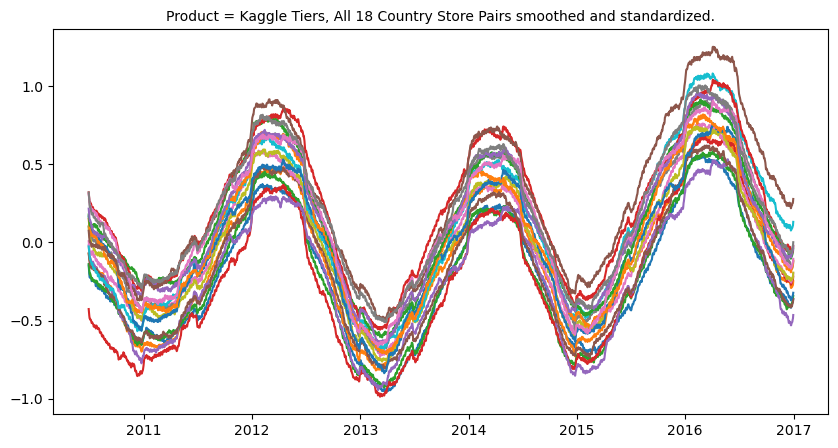

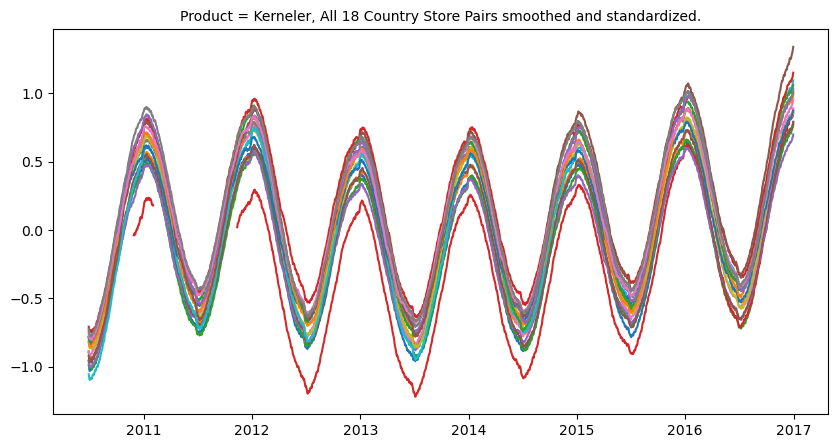

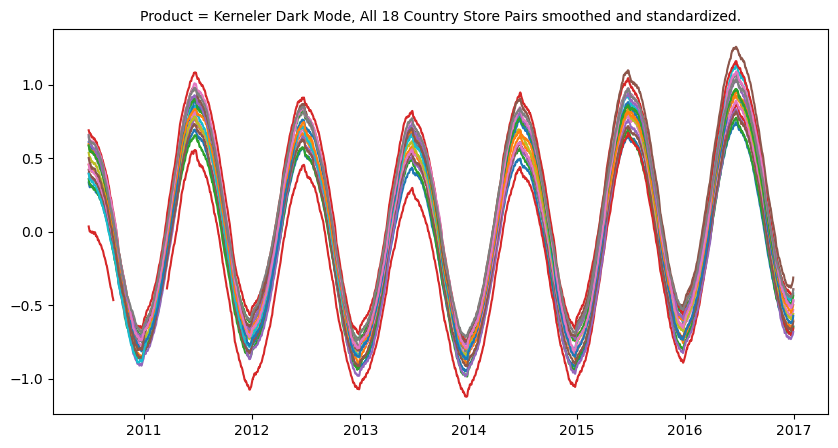

In [8]:
C = list( train.country.unique() )
S = list( train.store.unique() )
P = list( train["product"].unique() )
print("Countries:", C )
print("Stores:", S )
print("Products:", P)

# DATA IS PRODUCT X 7 YEARS X STORE+COUNTRY
data = np.zeros( (5,2557,18) )
for i in range(5):
    for j in range(3):
        for k in range(6):
            f = 1 
            if k==3: f=1.15 # FUDGE FACTOR FOR KENYA
            df = train.loc[(train.country==C[k])&(train.store==S[j])&(train["product"]==P[i])].copy()
            data[i,:,j*6+k] = df["num_sold"].values*f

# COMPUTE MEANS AND STDS
means = {}; stds = {}
for k in range(5):
    m = np.nanmean( data[k,:,:] )
    s = np.nanstd( data[k,:,:] )
    means[k]=m; stds[k]=s

# PLOT ALL TIME SERIES DATA
for i in range(5):
    plt.figure(figsize=(10,5))
    for j in range(3):
        for k in range(6):
            f = 1
            if k==3: f=1.15
            df = train.loc[(train.country==C[k])&(train.store==S[j])&(train["product"]==P[i])].copy()
            df["smooth_sold"] = df["num_sold"].rolling(window=180).mean()
            m = means[i]; s = stds[i]
            plt.plot(df["date"], (df["smooth_sold"]*f-m)/s )
            data[i,:,j*6+k] = (df["num_sold"].values*f-m)/s
    plt.title(f"Product = {P[i]}, All 18 Country Store Pairs smoothed and standardized.",size=10)
    plt.show()

In [9]:
### DataLoader로 Transformer Input 만들기

import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, product=0, f_length=768, t_length=32): 

        self.data = np.expand_dims(data,axis=-1)
        nans = np.isnan(self.data).astype('float32')
        self.data = np.concatenate([self.data,nans],axis=-1)
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.product = product
        self.f_length = f_length
        self.t_length = t_length
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int(np.ceil(32*1024/self.batch_size))
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( 32*1024 )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        SIZE = self.f_length
        TARGET = self.t_length
        X = np.zeros((len(indexes),SIZE,2),dtype='float32')
        y = np.zeros((len(indexes),TARGET),dtype='float32')
        
        for k in range(len(indexes)):
            r = np.random.randint(0,self.data.shape[2])
            a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
            y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            while np.isnan(y[k,:]).sum()>0:
                r = np.random.randint(0,self.data.shape[2])
                a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
                y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            X[k,:,:] = self.data[self.product,a:a+SIZE,r,:]

        return np.nan_to_num(X),np.nan_to_num(y)


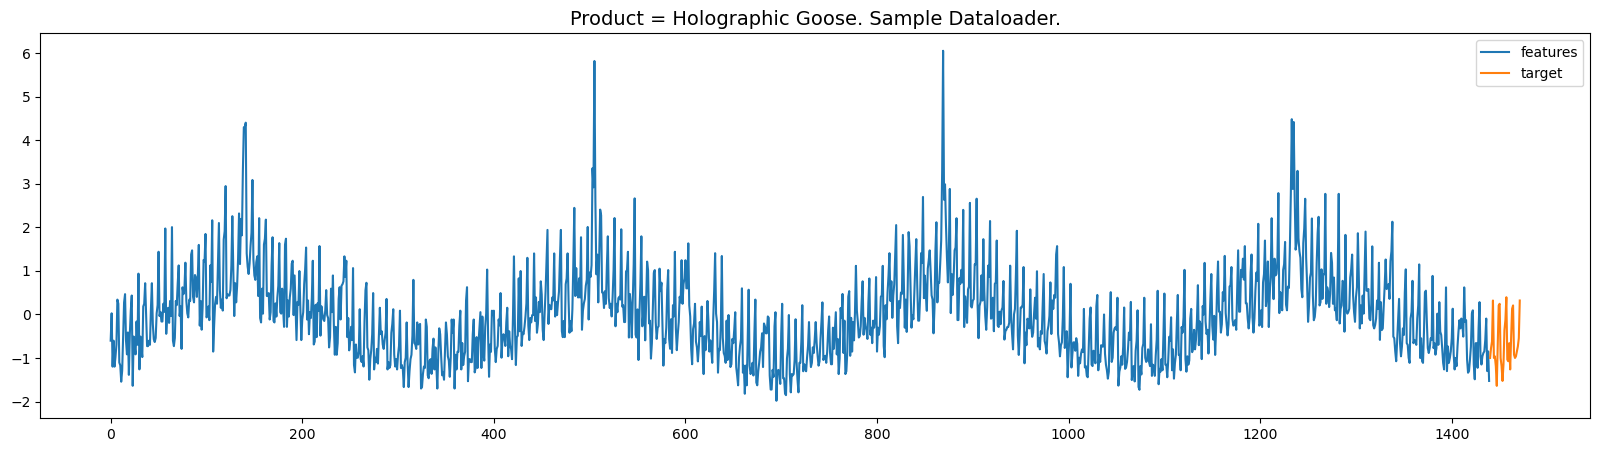

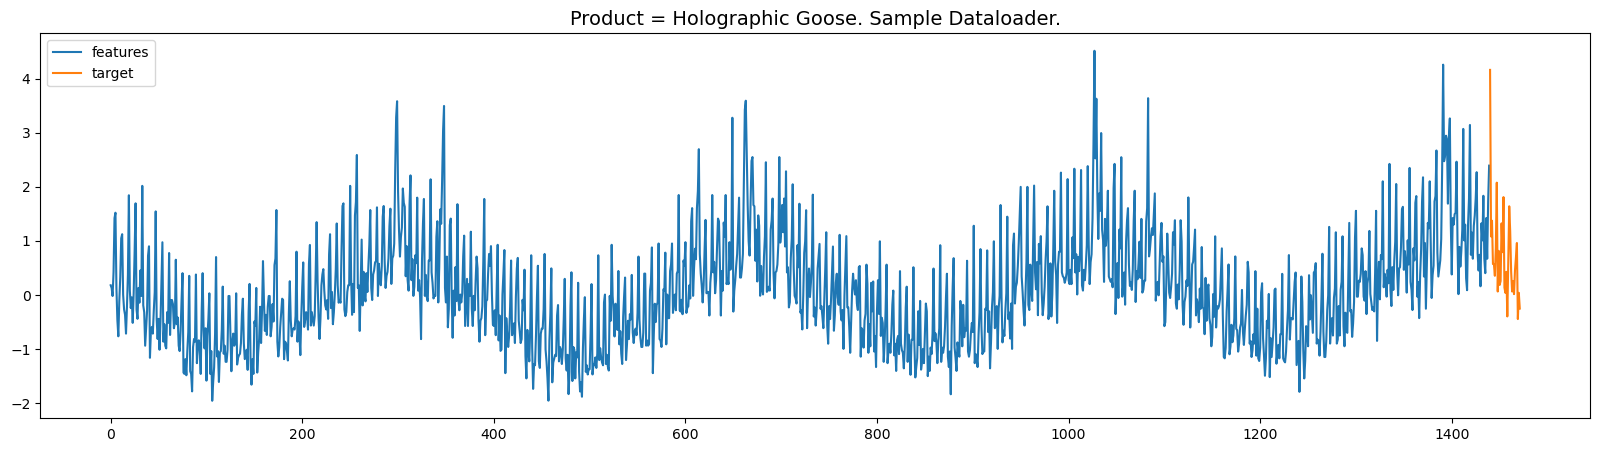

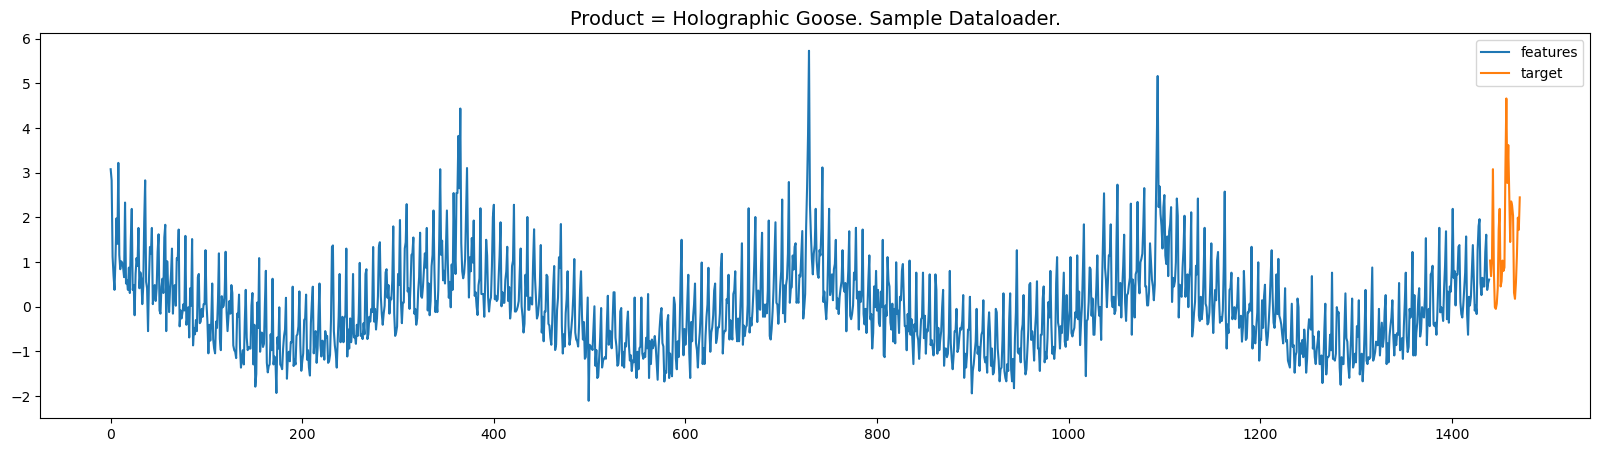

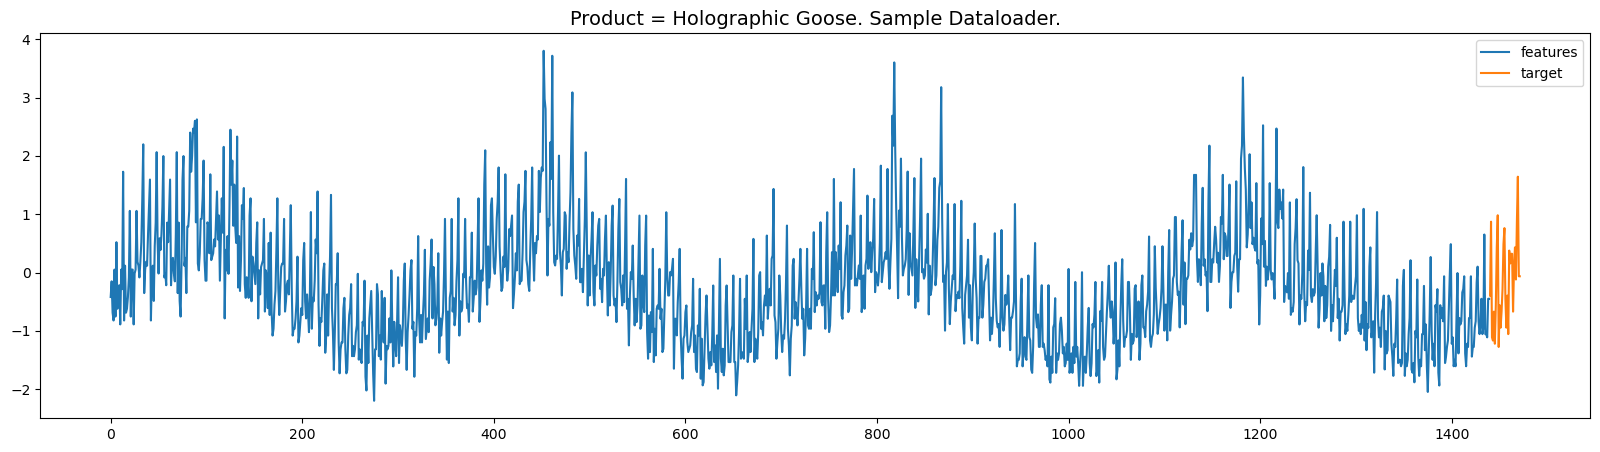

In [10]:
# VERSION
VER=1
# WHICH OF 5 PRODUCTS 0,1,2,3,4 TO TRAIN AND PREDICT
PROD = 0
# LENGTH OF TRAIN FEATURES
LEN = 1440

# DISPLAY DATA LOADER
gen = DataGenerator(data, shuffle=False, f_length=LEN, product=PROD)
for x,y in gen:
    for k in range(4):
        plt.figure(figsize=(20,5))
        LN = x.shape[1]
        LN2 = y.shape[1]
        plt.plot(np.arange(LN),x[k,:,0],label='features')
        plt.plot(np.arange(LN2)+LN,y[k,:],label='target')
        plt.legend()
        plt.title(f"Product = {P[PROD]}. Sample Dataloader.",size=14)
        plt.show()
    break

#### 2. Model Development

##### 2-1 Scheduling

Learning rate schedule: 0.001 to 0.001 to 1e-06


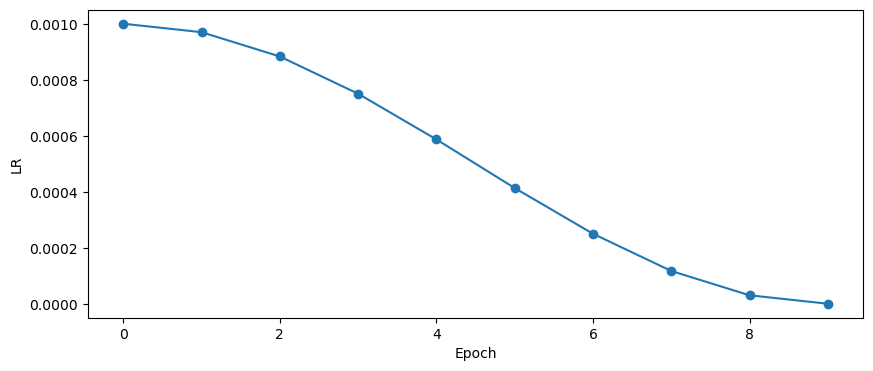

In [11]:
import math, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)


##### 2-2 Transformer Block 생성

In [12]:
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers

### 1. Transformer Block 생성
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):  
        attn_output = self.att(inputs, inputs, training=training)  
        attn_output = self.dropout1(attn_output, training=training)  
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)  
        return self.layernorm2(out1 + ffn_output)
    
    
### 2. Positional Encoding
def positional_encoding(maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

##### 2-3 WaveNet Layer 생성

In [13]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

##### 2-4 전체 Transformer Model 생성

In [14]:
feat_dim = 16 
embed_dim = 32  
num_heads = 4  
ff_dim = 64
dropout_rate = 0.0
num_blocks = 3

def build_model():
        
    # INPUT 
    inp = tf.keras.Input(shape=(LEN,2))
    
    # POSITIONAL ENCODING
    x = layers.Dense(feat_dim)(inp)
    p = positional_encoding(1440,feat_dim)
    x = x + p
    
    # THREE BLOCKS of WAVENET and TRANSFORMER
    for k in range(num_blocks):
        skip = x
        x = wave_block(x, feat_dim, 3, 12)
        x = wave_block(x, feat_dim, 3, 12)
        x = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)(x)
        x = 0.9*x + 0.1*skip 

    # HEAD
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32,activation='linear', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer = opt)
    
    return model

#### 3. Training

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
print('TensorFlow version =',tf.__version__)

# GPU 환경 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
# USE MIXED PRECISION
from tensorflow.keras.mixed_precision import set_global_policy

policy = 'mixed_float16'
set_global_policy(policy)
print(f"Mixed precision policy set to: {policy}")

TensorFlow version = 2.12.0
Using 0 GPU
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Mixed precision policy set to: mixed_float16


##### 3-1 Model Training

In [ ]:
os.makedirs(f'models_v{VER}', exist_ok=True)

train_gen = DataGenerator(data, shuffle=True, batch_size=64, f_length=LEN, product=PROD)
valid_gen = DataGenerator(data, shuffle=False, batch_size=128, f_length=LEN, product=PROD)

TRAIN_MODEL = True

with strategy.scope():
    model = build_model()

if TRAIN_MODEL:
    model.fit(train_gen, verbose=1,
          validation_data = valid_gen,
          epochs=EPOCHS, callbacks = [LR])
    model.save_weights(f'models_v{VER}/model_v{VER}_p{PROD}.weights.h5')
else:
    current_dir = os.path.dirname(os.path.abspath(__file__))
    PATH_DATA = os.path.join(current_dir, 'kaggle-sticker-comp-sub-v2')
    model.load_weights(f'{PATH_DATA}/model_v{VER}_p{PROD}.weights.h5')

#### 4. Predicting

In [ ]:
# ADD NAN INDICATOR FEATURE TO DATA
data = np.expand_dims(data,axis=-1)
nans = np.isnan(data).astype('float32')
data = np.concatenate([data,nans],axis=-1)

preds = np.zeros((18,32*35))

# ITERATE OVER ALL COMBINATIONS OF COUNTRY AND STORE FOR SPECIFIC PRODUCT
# PREDICT 3 YEARS INTO THE FUTURE

bad_rows = []
for jj in range(18):
    ddd0 = data[PROD:PROD+1,-LEN:,jj,:].copy()
    if np.isnan(ddd0[:,:,0]).sum()==LEN:
        bad_rows.append(jj)
    
    pp = []
    for j in range(0,35):
        print(j,", ",end="")
        if j==0: dd2 = ddd0
        else: dd2 = np.concatenate([ddd0[:,32*j:,:]]+pp,axis=1) 
        p2 = model.predict( np.nan_to_num(dd2[:,-LEN:,:]) ,verbose=0)
        p2 = p2.reshape((1,32,1)) # ADD NAN INDICATOR TO PREDICTIONS
        p2 = np.concatenate([p2,np.zeros_like(p2)],axis=-1)
        pp.append(p2)
        if j==34:
            print()
            plt.figure(figsize=(20,5))
            plt.plot(np.arange(LEN), np.nan_to_num(ddd0[0,:,0]) )
            for k in range(j+1):
                plt.plot(np.arange(32)+LEN+32*k,pp[k][0,:,0])
            cc = C[jj%6]
            ss = S[jj//6]
            plt.title(f"Product={P[PROD]}, Country={cc}, Store={ss}",size=16)
            plt.show()
            
    preds[jj,:] = np.concatenate([z[:,:,:1] for z in pp],axis=1).flatten()